In [1]:
import json
import pandas as pd
from pprint import pprint as pp
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import snappy
import fastparquet
import dask
import dask.dataframe as dd
import re
import nltk
#nltk.download('words')
#nltk.download('wordnet')

Load Data:

In [8]:
## extract paper with keywords ids
#papers_keywords = {}
#with open('../resources/papers_keywords.json') as f:
#    papers_keywords = json.load(f)
#ids = [p['id'] for p in papers_keywords['papers']]
#print(len(ids))
#
#data = {}
#with open('../resources/papers_subjects.json', 'r') as f:
#    data = json.load(f)
#    
## keep only papers with keywords
#papers_subjects = {'papers': []}
#for paper in data['papers']:
#    if paper['id'] in ids:
#        papers_subjects['papers'].append(paper)
#print(len(papers_subjects['papers']))
#
## save it
#with open('../resources/papers_k_subjects.json', 'w') as f:
#    json.dump(papers_subjects, f)

15118
15118


In [2]:
data = {}
with open('../resources/papers_k_subjects.json', 'r') as f:
    data = json.load(f)
print(len(data['papers']))

15118


Create Taxonomy:

In [3]:
def get_paper_subjects(paper):
    subjects = [paper['primary-subject']['id_subject']]
    subjects.extend([s['id_subject'] for s in paper['other-subjects']])
    return subjects

subjects_id_set = set()
c_p = 0

for paper in data['papers']:
    # add primary-subject
    primary_subject = paper['primary-subject']
    subjects_id_set.add((primary_subject['id_subject'], primary_subject['name_subject']))
    # check if the primary-subject is in 'Computer Science'
    if primary_subject['id_subject'].startswith('cs.'):
        c_p += 1
    # add other-subjects
    for other_s in paper['other-subjects']:
        subjects_id_set.add((other_s['id_subject'], other_s['name_subject']))
            
print("%s/%s papers has a 'cs' primary-subject." %(c_p, len(data['papers'])))
print("All papers cover %s subjects." % len(subjects_id_set))

12866/15118 papers has a 'cs' primary-subject.
All papers cover 114 subjects.


In [4]:
subjects_id_set

{('astro-ph', 'Astrophysics'),
 ('astro-ph.CO', 'Cosmology and Nongalactic Astrophysics'),
 ('astro-ph.EP', 'Earth and Planetary Astrophysics'),
 ('astro-ph.GA', 'Astrophysics of Galaxies'),
 ('astro-ph.HE', 'High Energy Astrophysical Phenomena'),
 ('astro-ph.IM', 'Instrumentation and Methods for Astrophysics'),
 ('astro-ph.SR', 'Solar and Stellar Astrophysics'),
 ('cond-mat.dis-nn', 'Disordered Systems and Neural Networks'),
 ('cond-mat.mtrl-sci', 'Materials Science'),
 ('cond-mat.stat-mech', 'Statistical Mechanics'),
 ('cs.AI', 'Artificial Intelligence'),
 ('cs.AR', 'Hardware Architecture'),
 ('cs.CC', 'Computational Complexity'),
 ('cs.CE', 'Computational Engineering, Finance, and Science'),
 ('cs.CG', 'Computational Geometry'),
 ('cs.CL', 'Computation and Language'),
 ('cs.CR', 'Cryptography and Security'),
 ('cs.CV', 'Computer Vision and Pattern Recognition'),
 ('cs.CY', 'Computers and Society'),
 ('cs.DB', 'Databases'),
 ('cs.DC', 'Distributed, Parallel, and Cluster Computing'),


Taxonomy: https://arxiv.org

- https://arxiv.org/archive/cs
- https://arxiv.org/archive/astro-ph
- https://arxiv.org/archive/cond-mat
- https://arxiv.org/archive/econ
- https://arxiv.org/archive/eess
- https://arxiv.org/archive/hep-ex
- https://arxiv.org/archive/hep-ph
- https://arxiv.org/archive/hep-th
- https://arxiv.org/archive/math-ph
- https://arxiv.org/archive/math
- https://arxiv.org/archive/nlin
- https://arxiv.org/archive/nucl-ex
- https://arxiv.org/archive/nucl-th
- https://arxiv.org/archive/physics
- https://arxiv.org/archive/q-bio
- https://arxiv.org/archive/q-fin
- https://arxiv.org/archive/quant-ph
- https://arxiv.org/archive/stat

Create DataSet:

In [5]:
%%time
from sklearn.preprocessing import OneHotEncoder
def get_encoder(subjects):
    enc = OneHotEncoder().fit(np.array(sorted([s[0] for s in subjects])).reshape(-1, 1))
    #print(enc.categories_)
    return enc

def get_paper_subjects(paper):
    subjects = [paper['primary-subject']['id_subject']]
    subjects.extend([s['id_subject'] for s in paper['other-subjects']])
    return subjects

def transform_paper_subjects(enc, paper_subjects):
    return sum(enc.transform(np.array(paper_subjects).reshape(-1, 1)).toarray()) #.todense()


data_df = []
columns_df = ['paper_id', 'primary-subject']
columns_df.extend(sorted([c[0] for c in subjects_id_set]))

enc = get_encoder(subjects_id_set)

for paper in data['papers']:
    #if paper['primary-subject']['id_subject'].startswith('cs.'):
    row_df = [paper['id'], paper['primary-subject']['id_subject']]
    paper_subjects = get_paper_subjects(paper)
    row_df.extend(transform_paper_subjects(enc, paper_subjects))
    data_df.append(row_df)

df = pd.DataFrame(data=data_df, columns=columns_df, dtype=np.uint8)
df

Wall time: 4.51 s


,paper_id,primary-subject,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.dis-nn,...,q-fin.PM,q-fin.RM,q-fin.ST,q-fin.TR,quant-ph,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT
0,61826,stat.ML,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,61836,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,61852,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,61907,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,61911,cs.AI,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15113,101196,cs.CV,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15114,101198,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15115,101216,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15116,101217,cs.LG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
def get_primary_subject_by_paper_id(paper_id):
    paper_row = df.loc[df.paper_id == paper_id]
    return paper_row['primary-subject'].to_numpy()[0]

def get_all_subjects_by_paper_id(paper_id):
    paper_row = df.loc[df.paper_id == paper_id].squeeze()
    return paper_row.index[paper_row == 1].to_list()

In [7]:
%%time
# check:
count = 0
for paper in data['papers']:
    #if paper['primary-subject']['id_subject'].startswith('cs.'):
    if paper['primary-subject']['id_subject'] != get_primary_subject_by_paper_id(paper['id']):
        print("Error primary-subject for %s." % paper['id'])
    else:
        if sorted(get_paper_subjects(paper)) != get_all_subjects_by_paper_id(paper['id']):
            print("Error all-subject for %s." % paper['id'])
        else:
            count += 1
print(count)

15118
Wall time: 56.7 s


In [8]:
BYTES_TO_MB_DIV = 0.000001
def print_memory_usage_of_data_frame(df):
    mem = round(df.memory_usage().sum() * BYTES_TO_MB_DIV, 3) 
    print("Memory usage is " + str(mem) + " MB")

print_memory_usage_of_data_frame(df)

Memory usage is 1.965 MB


Visualize paper-subjects:

In [9]:
subjects_counts = []
for s in subjects_id_set:
    subjects_counts.append((s[0],df[s[0]].sum()))

df_stats = pd.DataFrame(subjects_counts, columns=['subject', 'number_of_papers'])
df_stats

,subject,number_of_papers
0,astro-ph.IM,21
1,physics.comp-ph,17
2,astro-ph.HE,1
3,cs.PF,23
4,cs.DC,87
...,...,...
109,hep-th,2
110,cs.SC,2
111,math.ST,131
112,math.GR,1


Text(0.5, 0, 'subject')

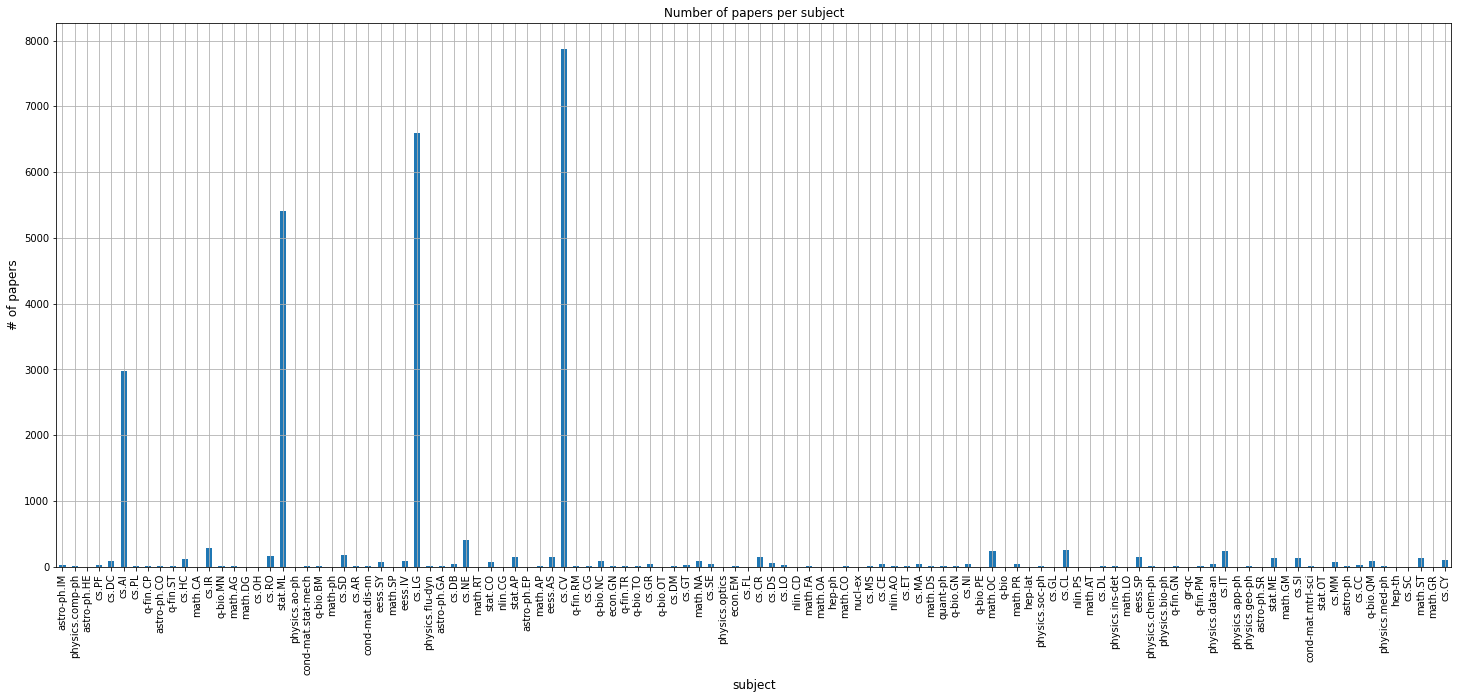

In [10]:
df_stats.plot(x='subject', y='number_of_papers', kind='bar', legend=False, grid=True, figsize=(25, 10))
plt.title("Number of papers per subject")
plt.ylabel('# of papers', fontsize=12)
plt.xlabel('subject', fontsize=12)

<AxesSubplot:>

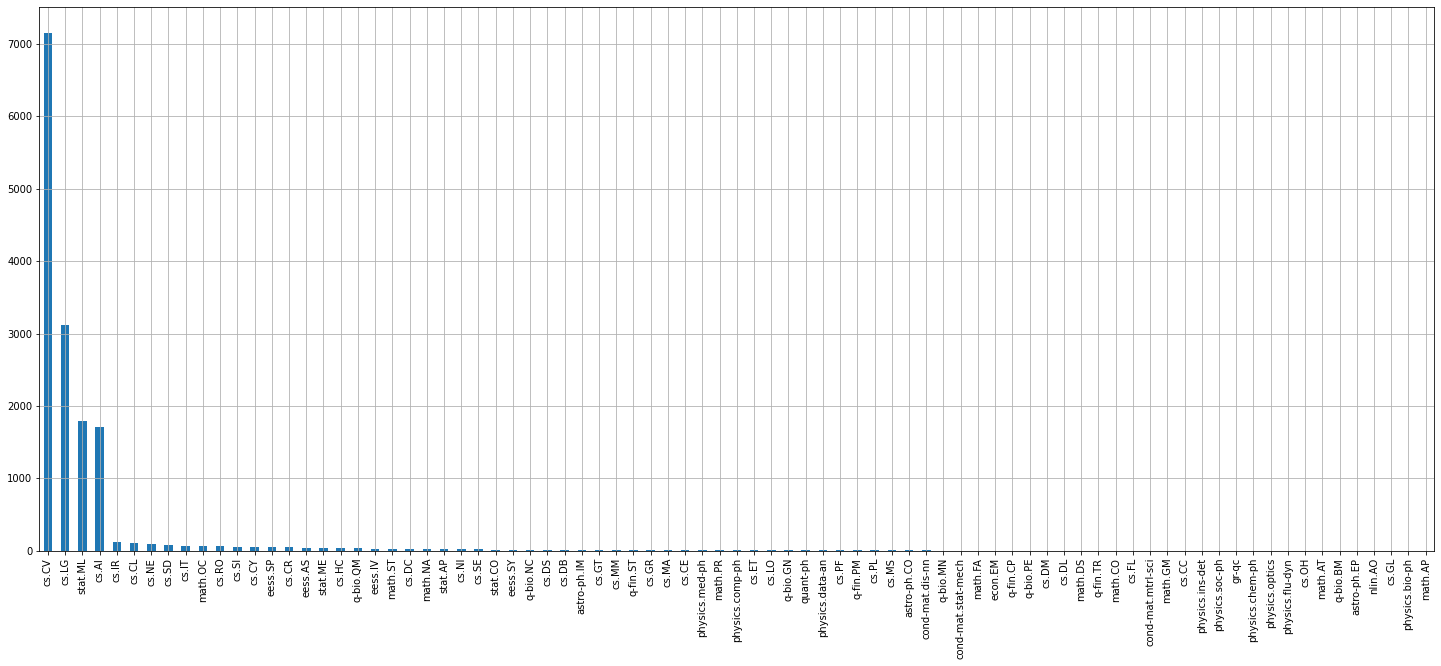

In [11]:
df['primary-subject'].value_counts().plot(kind='bar', grid=True, figsize=(25, 10))

Split papers with subject 'cs.CV' from the others without 'cs.CV':

In [ ]:
df_cv = df.loc[df['cs.CV'] == 1]
ids_cv_list = list(df_cv['paper_id'])
df_others = df.loc[df['cs.CV'] == 0]
ids_others_list = list(df_others['paper_id'])
print("%s + %s  = %s" %(len(ids_cv_list),len(ids_others_list),len(ids_cv_list)+len(ids_others_list)))

In [ ]:
split_data = {'papers_cv': ids_cv_list, 'papers_others': ids_others_list}
with open('../reosurces/paper_id_cv_notcv.json', 'w') as f:
    json.dump(split_data, f)

Load papers text:

In [12]:
%%time
data_dir = "../../data/papers"
parquets_dir = "../resources/papers-k-parquets"
df_text = pd.DataFrame(columns=["paper_id", "text"])
count_papers = 0
count_parquets =0
for paper_id in list(df['paper_id']):
    # extract entire text from txt
    paper_dir = os.path.join(data_dir, 'paper_'+paper_id)
    if os.path.isdir(paper_dir):
        paper_txt = os.path.join(paper_dir, 'paper_'+paper_id+'.txt')
        if os.path.isfile(paper_txt):
            text = ''
            with open(paper_txt, 'r', encoding='utf-8') as f:
                text = f.read()
            df_text = df_text.append({'paper_id': paper_id, 'text': text}, ignore_index=True)
            count_papers += 1
        else:
            print("Error: '%s' not found." % paper_txt)
    else:
        print("Error: '%s' not found." % paper_dir)
    # save in parquet
    if count_papers == 2000: # 2 2000
        parquet_path = os.path.join(parquets_dir, 'papers-k-'+'{:0>2d}'.format(count_parquets)+'.snap.parquet')
        #parquet_path = parquet_path.replace('\\', '/')
        fastparquet.write(parquet_path, df_text, compression='snappy')
        print(parquet_path)
        count_parquets += 1
        count_papers = 0
        df_text = pd.DataFrame(columns=["paper_id", "text"])
# save in last parquet
if count_papers > 0:
    parquet_path = os.path.join(parquets_dir, 'papers-k-'+'{:0>2d}'.format(count_parquets)+'.snap.parquet')
    #parquet_path = parquet_path.replace('\\', '/')
    fastparquet.write(parquet_path, df_text, compression='snappy')
    print(parquet_path)
    count_parquets += 1

../resources/papers-k-parquets\papers-k-00.snap.parquet
../resources/papers-k-parquets\papers-k-01.snap.parquet
../resources/papers-k-parquets\papers-k-02.snap.parquet
../resources/papers-k-parquets\papers-k-03.snap.parquet
../resources/papers-k-parquets\papers-k-04.snap.parquet
../resources/papers-k-parquets\papers-k-05.snap.parquet
../resources/papers-k-parquets\papers-k-06.snap.parquet
../resources/papers-k-parquets\papers-k-07.snap.parquet
Wall time: 2min 12s


Clean papers text:

In [2]:
from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=4, processes=False, memory_limit='6GB')
client

Client Scheduler: inproc://192.168.1.14/8432/1 Dashboard: http://192.168.1.14:8787/status,Cluster Workers: 1 Cores: 4 Memory: 6.00 GB


In [3]:
%%time
parquets_dir = "../resources/papers-k-parquets"
ddf = dd.read_parquet(parquets_dir, index=False, engine='fastparquet')
ddf.compute()

Wall time: 4.02 s


,paper_id,text
0,61826,Discrete Restricted Boltzmann Machines\nGuido ...
1,61836,Knowledge Matters: Importance of Prior Informa...
2,61852,Deep Learning for Detecting Robotic Grasps\nIa...
3,61907,On the number of response regions of deep\nfee...
4,61911,Avoiding Confusion between Predictors and Inhi...
...,...,...
1113,101196,Modeling Human Categorization of Natural Image...
1114,101198,arXiv:1810.04246v1\n[cs.LG]\n9\nOct\n2018 1\nD...
1115,101216,BézierGAN: Automatic Generation of Smooth Cur...
1116,101217,Channel Locality Block: A Variant of\nSqueeze-...


In [4]:
# merge lines and text cleaning
def merge_lines(text):
    lines = [l.strip() for l in text.strip().split('\n')]
    merged_lines = ""
    for line in lines:
        if len(line)>0:
            if line[-1]=='-':
                merged_lines = merged_lines+' '+line[:-1]
            else:
                merged_lines = merged_lines+' '+line
    return merged_lines.strip()

def initial_text_cleaning(text):
    text = text.lower()                                             # transform to lowercase
    text = re.sub(r'\n', '', text)                                  # remove \n
    text = re.sub(r'(\(|\[|\{)[^(\)|\]|\})]*(\)|\]|\})', '', text)  # remove everything in parentheses
    text = re.sub(r'http(s)?:\/\/\S+', '', text)                    # remove url
    text = re.sub(r'[^a-z\s]', '', text)  #[^\w\s]                  # remove everything that is not a word (therefore also numbers and punctuation)
    text = re.sub(r'\b\w{1,2}\b', '', text)                         # remove all single and double letters
    text = re.sub(r'\b(h|i|j|k|x|y)+\b', '', text)                  # remove some common letters used in formules 
    text = re.sub(r'\s{2,}', ' ', text).strip()                     # reformat spaces
    return text


# cleaning text of stop words
from nltk.corpus import stopwords
def remove_stopwords(text, stopwords):
    words = text.split()
    return ' '.join([w for w in words if w not in stopwords])

# cleaning text of nonsense words
from nltk.corpus import words
words_dictionary = set(words.words())
def remove_nonsensewords(text):
    words = text.split()
    return ' '.join([w for w in words if w in words_dictionary])


# stemming and lemmatization
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
def stemming(text):
    words = text.split()
    return ' '.join([porter.stem(w) for w in words])

from nltk.stem.wordnet import WordNetLemmatizer
wordnet = WordNetLemmatizer()
def lemmatization(text):
    words = text.split()
    return ' '.join([wordnet.lemmatize(w) for w in words])

In [5]:
%%time
# merge lines:
ddf['text'] = ddf['text'].apply(merge_lines, meta=(None, 'object'))

# text - cleaning:
ddf['text'] = ddf['text'].apply(initial_text_cleaning, meta=(None, 'object'))

# remove stop-words:
stopwords_file = "../resources/stopwords_list.txt"
stopwords_extended_list = stopwords.words('english')
with open(stopwords_file, 'r') as file:
    stopwords_extended_list.extend([line.replace('\n', '') for line in file.readlines()])
stopwords_extended_list.extend(['table', 'tab', 'figure', 'fig', 'arxiv', 'arxivv'])
stopwords = set(stopwords_extended_list)
ddf['text'] = ddf['text'].apply(lambda x: remove_stopwords(x, stopwords), meta=(None, 'object'))

## stemming and lemmatization:
ddf['text'] = ddf['text'].apply(stemming, meta=(None, 'object'))
#ddf['text'] = ddf['text'].apply(lemmatization, meta=(None, 'object'))

# remove nonsense-words:
#ddf['text'] = ddf['text'].apply(remove_nonsensewords, meta=(None, 'object'))

Wall time: 63.9 ms


In [6]:
%%time
ddf.compute()

distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.20 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.20 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.21 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.22 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARNING - Memory use is high but worker has no data to store to disk.  Perhaps some other process is leaking memory?  Process memory: 4.22 GB -- Worker memory limit: 6.00 GB
distributed.worker - WARN

Wall time: 21min 9s


,paper_id,text
0,61826,discret restrict boltzmann machin guido montuf...
1,61836,knowledg matter import prior optim caglar gulc...
2,61852,deep learn detect robot grasp lenz honglak ash...
3,61907,number respons region deep feedforward network...
4,61911,avoid confus predictor inhibitor valu function...
...,...,...
1113,101196,model human categor natur imag deep featur rep...
1114,101198,oct deep cluster link discrimin model kmean ja...
1115,101216,beziergan automat gener smooth curv interpret ...
1116,101217,channel local block variant squeezeandexcit hu...


Save text-clean dataset:

In [7]:
%%time
clean_parquets_dir = "../resources/papers-k-textclean-parquets"
dd.to_parquet(ddf, clean_parquets_dir, engine='fastparquet', compression='snappy')

Wall time: 20min 37s
